# Wind Time Series Script
 

#### Import the modules

In [3]:
# import the modules you will need for this notebook
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import requests
import os
import argparse
import cmocean.cm as cm
import cartopy 
import cartopy.crs as ccrs
import pandas as pd

Define spatial scale and file pathway

lon indices 937 955
lat indices 487 535


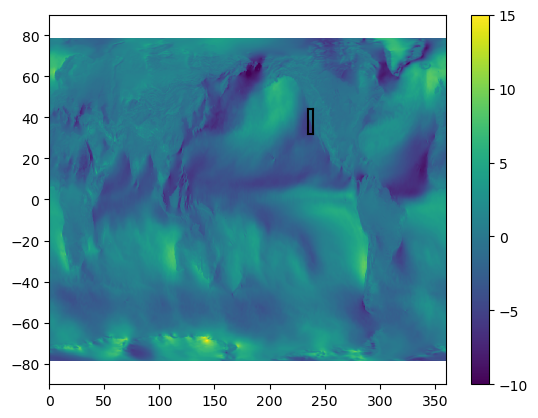

Shape of wind data: (720, 1440)


In [4]:
# define the longitude and latitude bounds, central california
min_lon = 234.5
max_lon = 239
min_lat = 32
max_lat = 44

# open the file and read in the ssh variable to a 2D numpy grid
ds = nc4.Dataset(test_file_path)
longitude = np.array(ds.variables["longitude"])
latitude = np.array(ds.variables["latitude"])
wind = np.array(ds.variables['v'])
ds.close()

# find the indices of the box bounds in the lon and lat grids
min_lon_index = np.argmin(np.abs(longitude-min_lon))
max_lon_index = np.argmin(np.abs(longitude-max_lon))
min_lat_index = np.argmin(np.abs(latitude-min_lat))
max_lat_index = np.argmin(np.abs(latitude-max_lat))

# print the indices to be sure these are ordered correctly
print('lon indices', min_lon_index, max_lon_index)
print('lat indices', min_lat_index, max_lat_index)

#to make sure we are looking were we want to 
def plot_box(ax, min_lon, min_lat, max_lon, max_lat):
    ax.plot([min_lon, min_lon], [min_lat, max_lat], 'k-')
    ax.plot([max_lon, max_lon], [min_lat, max_lat], 'k-')
    ax.plot([min_lon, max_lon], [min_lat, min_lat], 'k-')
    ax.plot([min_lon, max_lon], [max_lat, max_lat], 'k-')

# make a figure, to check bounding box
fig = plt.figure()
C = plt.pcolormesh(longitude, latitude, wind, vmin=-10, vmax=15)
plt.colorbar(C)
plot_box(plt.gca(), min_lon, min_lat, max_lon, max_lat)
plt.show()
print("Shape of wind data:", wind.shape)

In [5]:
# Define the longitude and latitude bounds
min_lon = 234.5
max_lon = 239
min_lat = 32
max_lat = 44

# Prepare empty lists to store the results
dates = []
winds = []

# Define the folder containing the .nc files
data_folder = r"D:\Remote sensing\Project\wind"

# Get a sorted list of .nc files in the folder
file_list = [f for f in os.listdir(data_folder) if f.endswith(".nc")]
file_list.sort()

# Loop through each file
for file_name in file_list:
    # Construct the full file path
    file_path = os.path.join(data_folder, file_name)
    
    # Extract the date from the filename (assuming it's in '200302' format)
    date_str = file_name.split('_')[3]
    
    # Open the NetCDF file
    ds = nc4.Dataset(file_path)
    
    # Read in the necessary variables
    longitude = np.array(ds.variables["longitude"])
    latitude = np.array(ds.variables["latitude"])
    wind = np.array(ds.variables['v']) 
    
    # Find the indices of the box bounds in the lon and lat grids
    min_lon_index = np.argmin(np.abs(longitude - min_lon))
    max_lon_index = np.argmin(np.abs(longitude - max_lon))
    min_lat_index = np.argmin(np.abs(latitude - min_lat))
    max_lat_index = np.argmin(np.abs(latitude - max_lat))
    
    # Sample the wind data within the box
    wind_box = wind[min_lat_index:max_lat_index+1, min_lon_index:max_lon_index+1]
    # Store the results
    dates.append(date_str)
    winds.append(np.mean(wind_box))
    
    # Close the dataset
    ds.close()

# Convert the lists to numpy arrays if needed
dates = np.array(dates)
winds = np.array(winds)

# Print the results to verify
#print("Dates:", dates)
print("Shape of wind data:", winds.shape)

Shape of wind data: (204,)


Now we are going to subset the years for monthly averages across upwelling months

In [6]:
data = pd.DataFrame({'date': dates, 'wind': winds})

# Extract year and month from the date string (assuming '200302' format: YYYYMM)
data['year'] = data['date'].str[:4].astype(int)
data['month'] = data['date'].str[4:6].astype(int)

# Filter for the months April (4), May (5), and June (6)
spring_data = data[data['month'].isin([4, 5, 6])]

# Group by year and calculate the mean wind for each year
yearly_avg_winds = spring_data.groupby('year')['wind'].mean()

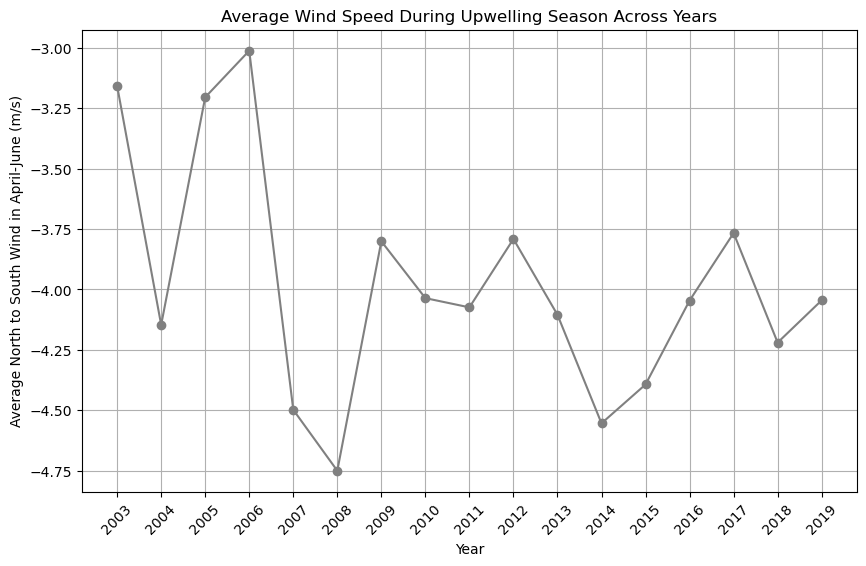

In [7]:
# Define the years for x-axis labels
years = list(range(2003, 2020))

# Plot the yearly average winds
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg_winds.index, yearly_avg_winds.values, marker='o', color='grey', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average North to South Wind in April-June (m/s)')
plt.title('Average Wind Speed During Upwelling Season Across Years')
plt.xticks(years, rotation=45)
plt.grid()
plt.show()

Export to CSV for the correlation code

In [8]:
yearly_avg_winds.to_csv("Wind_yearly_timeseries.csv", header=False, index=True)

In [12]:
# create a new figure with size (8,5)
plt.figure(figsize=(8,5))

# add a new set of axes with the Robinson projection
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=250))

# add the coastlines and stock image
ax.stock_img()

# add a box with your specific coordinates
min_lon, max_lon = -119, -125.5
min_lat, max_lat = 32, 44

# Create box corners
box_coords = [
    [min_lon, min_lat],
    [min_lon, max_lat],
    [max_lon, max_lat],
    [max_lon, min_lat],
    [min_lon, min_lat]
]

# Plot the box
xs, ys = zip(*box_coords)
ax.plot(xs, ys, transform=ccrs.PlateCarree(), color='red', linewidth=2)

plt.savefig('study_area_map.png', dpi=300, bbox_inches='tight')
plt.close()